In [78]:

import pandas as pd
import numpy as np3ed
import numpy as np
import random
import time
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import TruncatedSVD
from lightfm import LightFM
from lightfm.data import Dataset as LFDataset
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt 
import plotly.graph_objects as go


In [79]:

# 1) LOAD & SPLIT THE DATASET
df = pd.read_excel('online_retail.xlsx', parse_dates=['InvoiceDate'])
df = df.rename(
    columns={'Invoice': 'Invoice',
             'Price':   'Price',
             'Customer ID': 'CustomerID'}
).dropna(subset=['CustomerID'])
last_date = df['InvoiceDate'].max()
cutoff    = last_date - timedelta(days=100)
print(f"Last date:   {last_date}")
print(f"Cutoff date: {cutoff}")
train_df  = df[df['InvoiceDate'] <= cutoff]
test_df   = df[df['InvoiceDate']  > cutoff]


Last date:   2010-12-09 20:01:00
Cutoff date: 2010-08-31 20:01:00


In [80]:

# 2) AGGREGATE TRAIN INTERACTIONS
train_inter = (train_df
    .groupby(['CustomerID','StockCode'])['Quantity']
    .sum()
    .reset_index()
)
# True items per user in test period
test_true = test_df.groupby('CustomerID')['StockCode'].apply(set).to_dict()

In [81]:
# Step 1: Drop NAs
#Both StockCode (item ID) and CustomerID (user ID) must be present to build meaningful user-item interaction data.
#Rows with missing values are dropped.
train_inter = train_inter.dropna(subset=['StockCode', 'CustomerID']) 

# Step 2: Clean types
train_inter['StockCode'] = train_inter['StockCode'].astype(str)
train_inter['CustomerID'] = train_inter['CustomerID'].astype('Int64').astype(str)

# Step 3: Ensure test_true keys match format
test_true = {str(int(float(u))): items for u, items in test_true.items()}

# Step 4: Filter only users in training
train_users = set(train_inter['CustomerID'].unique())
test_true = {u: items for u, items in test_true.items() if u in train_users}

# Step 5: Check intersection
test_users = set(test_true.keys())
common_users = test_users & train_users

print("Users in test_true:", len(test_users))
print("Users in training:", len(train_users))
print("Common users between train and test:", len(common_users))

Users in test_true: 2044
Users in training: 3393
Common users between train and test: 2044


In [82]:
# 3) APRIORI RECOMMENDER
# Filter top users and top items to reduce data size
# Create basket matrix
basket = (
    train_inter[
        train_inter['CustomerID'].isin(
            train_inter['CustomerID'].value_counts().head(10000).index
        ) & train_inter['StockCode'].isin(
            train_inter['StockCode'].value_counts().head(1000).index
        )
    ]
    .pivot(index='CustomerID', columns='StockCode', values='Quantity')
    .fillna(0)
    .applymap(lambda x: 1 if x > 0 else 0)
)

print("Basket shape:", basket.shape)

# Run Apriori with optimizations
start = time.time()
freq_items = apriori(
    basket,
    min_support=0.05,
    use_colnames=True,
    max_len=2,              # ❗ limits itemset combinations to 2
    verbose=0               # silent mode
)
print("Frequent itemsets:", len(freq_items))

rules = association_rules(
    freq_items,
    metric='confidence',
    min_threshold=0.3
)
print("Rules generated:", len(rules))
print("Time taken:", round(time.time() - start, 2), "sec")
# Apriori recommender function
def apriori_recs(user, k=5):
    if user not in basket.index:
        return []
    seen = set(basket.columns[basket.loc[user] == 1])
    hits = []
    for _, r in rules.iterrows():
        if r['antecedents'].issubset(seen):
            hits += [i for i in r['consequents'] if i not in seen]
    return list(dict.fromkeys(hits))[:k]

/var/folders/yg/g_v7phk13835m6ybvtz5lxmw0000gp/T/ipykernel_1480/2250900539.py:14: FutureWarning:

DataFrame.applymap has been deprecated. Use DataFrame.map instead.



Basket shape: (3318, 1000)


/opt/homebrew/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:161: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



Frequent itemsets: 312
Rules generated: 142
Time taken: 2.16 sec


In [83]:

# 4) SVD COLLABORATIVE FILTER

ui_mat = train_inter.pivot(
    index='CustomerID', columns='StockCode', values='Quantity'
).fillna(0)

# Convert column names to strings to avoid SVD error
ui_mat.columns = ui_mat.columns.astype(str)


svd = TruncatedSVD(n_components=50, random_state=42)
user_factors = svd.fit_transform(ui_mat)
item_factors = svd.components_.T
def svd_recs(user, k=5):
    if user not in ui_mat.index:
        return []
    uidx   = ui_mat.index.get_loc(user)
    scores = user_factors[uidx] @ item_factors.T
    seen   = set(ui_mat.columns[ui_mat.iloc[uidx]>0])
    cands  = [(item,score) for item,score in zip(ui_mat.columns,scores)
              if item not in seen]
    return [i for i,_ in sorted(cands, key=lambda x: x[1], reverse=True)[:k]]

In [84]:
# CLEANING STEP: Filter and convert
train_inter = train_inter.dropna(subset=['StockCode', 'CustomerID'])
train_inter['StockCode'] = train_inter['StockCode'].astype(str)
train_inter['CustomerID'] = train_inter['CustomerID'].astype(str)

train_users = set(train_inter['CustomerID'].unique())

# Filter test_true to only users that are in training
test_true = {u: items for u, items in test_true.items() if u in train_users}
test_users = set(test_true.keys())  # ✅ moved here, after filtering

common_users = test_users & train_users
print("Users in test_true:", len(test_users))
print("Users in training:", len(train_users))
print("Common users between train and test:", len(common_users))
# 5) LIGHTFM HYBRID

lf_ds = LFDataset()
lf_ds.fit(users=train_inter['CustomerID'], items=train_inter['StockCode'])

interactions,_ = lf_ds.build_interactions(
    list(train_inter.itertuples(index=False, name=None))
)
lf_model = LightFM(no_components=50, loss='warp', random_state=42)
lf_model.fit(interactions, epochs=20, num_threads=4)
mapping = lf_ds.mapping()[2]
inv_map = {v:k for k,v in mapping.items()}
def lfm_recs_batch(users, k=5):
    user_map = lf_ds.mapping()[0]
    item_map = lf_ds.mapping()[2]
    recs = {}
    
    for u in users:
        try:
            if u not in user_map:
                continue
            ux = user_map[u]
            scores = lf_model.predict(ux, np.arange(len(item_map)))
            if not hasattr(scores, '__iter__'):
                raise TypeError("Prediction output is not iterable")

            ranked = np.argsort(-scores)
            seen = set(train_inter[train_inter['CustomerID'] == u]['StockCode'])
            rec_list = []
            for iid in ranked:
                if iid in inv_map:
                    item = inv_map[iid]
                    if item not in seen:
                        rec_list.append(item)
                if len(rec_list) == k:
                    break
            recs[u] = rec_list
        except Exception as e:
            print(f"LightFM failed for user {u}: {e}")
            recs[u] = []
    return recs


Users in test_true: 2044
Users in training: 3393
Common users between train and test: 2044


In [85]:
# Training LightFM
lf_model = LightFM(no_components=50, loss='warp', random_state=42)
lf_model.fit(interactions, epochs=20, num_threads=4)

# ------------------- ADD THIS BLOCK BELOW -------------------
# Filter test_true users that exist in LightFM mapping
users = [u for u in test_true if u in lf_ds.mapping()[0]]
print("Users in test_true:", len(test_true))
print("Common users:", len(users))

# OPTIONAL: Check how many users return non-empty recommendations
recs = lfm_recs_batch(users)
non_empty = sum(1 for v in recs.values() if v)
print(f"Non-empty recs: {non_empty} / {len(users)}")
# ------------------------------------------------------------

# Now pass `recs` to your metrics functions


Users in test_true: 2044
Common users: 2044
Non-empty recs: 2044 / 2044


In [86]:
print("Users in recs:", len(recs))
print("Users in test_true:", len(test_true))
print("Common users:", len(set(recs) & set(test_true)))
def precision_recall(recs, true, k=5):
    P, R, n = 0, 0, 0
    for u, tset in true.items():
        preds = recs.get(u, [])
        if not preds or not tset:
            continue
        hits = set(preds) & tset
        print(f"User: {u}, Preds: {preds}, True: {tset}, Hits: {hits}")
        P += len(hits) / min(len(preds), k)
        R += len(hits) / len(tset)
        n += 1
    return (P / n if n > 0 else 0.0), (R / n if n > 0 else 0.0)


Users in recs: 2044
Users in test_true: 2044
Common users: 2044


In [87]:
def coverage(recs, all_items):
    """
    Normalized coverage metrics:
    - User coverage: % of users with recommendations
    - Item coverage: % of catalog covered by recommendations
    """
    all_items_set = set(all_items)  # Convert to set for intersection
    recommended_items = {item for user_recs in recs.values() for item in user_recs}
    users_with_recs = sum(1 for rec in recs.values() if rec)

    user_cov = users_with_recs / len(recs) if len(recs) > 0 else 0
    item_cov = len(recommended_items & all_items_set) / len(all_items_set) if len(all_items_set) > 0 else 0

    return round(min(user_cov, 1.0), 4), round(min(item_cov, 1.0), 4)

In [88]:

def novelty_diversity_approx(recs, all_items=None):
    import math
    from collections import Counter

    all_recs = [item for rec in recs.values() for item in rec]
    total_users = len(recs)

    if not all_recs or total_users == 0:
        return 0.0, 0.0

    item_counts = Counter(all_recs)
    novelty_raw = -sum(
        (count / total_users) * math.log((count / total_users) + 1e-10)
        for count in item_counts.values()
    )

    num_items = len(all_items) if all_items else len(set(all_recs))
    max_entropy = math.log(num_items + 1e-10)
    novelty_norm = novelty_raw / max_entropy if max_entropy > 0 else 0

    unique_items = set(all_recs)
    diversity_raw = len(unique_items) / len(all_recs)
    diversity_norm = diversity_raw

    return round(novelty_norm, 4), round(diversity_norm, 4)

In [89]:

# 7) RUN & COLLECT METRICS
# Check how many users have overlap between recommended and ground truth items
overlap_counts = [len(set(recs[u]) & set(test_true.get(u, []))) for u in recs]
print(f"Users with ≥1 correct recs: {sum(np.array(overlap_counts) > 0)} / {len(recs)}")

results = []
all_items = train_inter['StockCode'].unique()

lfm_user_recs = lfm_recs_batch([u for u in users if u in lf_ds.mapping()[0]])

def lfm_recs(user):
    return lfm_user_recs.get(user, [])

for name, alg in [
    ('Apriori', apriori_recs),
    ('SVD', svd_recs),
    ('LightFM', lfm_recs)
]:
    print(f"Running: {name}")
    recs = {}
    for u in users:
        try:
            r = alg(u)
            # Ensure output is a list
            if not isinstance(r, list):
                print(f"{name} returned non-list for user {u}: {r}")
                r = []
            recs[u] = r
        except Exception as e:
            print(f"{name} failed for user {u}: {e}")
            recs[u] = []

    p, r = precision_recall(recs, test_true)
    uc, ic = coverage(recs, all_items)
    nov, div = novelty_diversity_approx(recs)
    results.append({
        'Engine': name,
        'Precision@5': p,
        'Recall@5': r,
        'User-Coverage': uc,
        'Item-Coverage': ic,
        'Novelty': nov,
        'Diversity': div
    })

eval_df = pd.DataFrame(results)
eval_df

Users with ≥1 correct recs: 113 / 2044
Running: Apriori
User: 12346, Preds: ['85123A'], True: {'D', 'TEST001'}, Hits: set()
User: 12349, Preds: ['21212', '85123A', '22423'], True: {48129, '16156S', 84879, '85014B', 22168, 22553, 21787, 22556, 22555, 22690, 22692, 22181, 'POST', 22059, 22701, 22703, 22705, 22326, 22072, 22457, 48188, 22848, '85014A', 48194, 22081, 22852, 22853, 85064, 21577, 85068, 20685, 22478, 22863, 22483, 22740, '16161P', 21340, 22497, 22626, 22627, '48173C', 22759, 22760, 21484, 22637, 21231, 21232, 48111, 48116, 22136, 20985, 21498, 22907, 22652, 22654}, Hits: set()
User: 12358, Preds: ['22386', '85099B'], True: {'15056N', 22775, '15058B', 'POST', 22059, 22837, '15056P', '15056BL', 20679, 37450, '47567B', 22366, 22114, 21481, 22890, 21231, 21232, 22644, 22772, 22646, 22774, 22649, 37500}, Hits: set()
User: 12359, Preds: ['48138', '20725', '21212', '84991', '85123A'], True: {21889, 22668, 21907, 22676, 22677, 22678, 22423, 21272, 22681, 22682, 22683, 22684, 22685, 

,Engine,Precision@5,Recall@5,User-Coverage,Item-Coverage,Novelty,Diversity
0,Apriori,0.018860,0.001328,0.8586,0.0138,1.8194,0.0078
1,SVD,0.006262,0.001234,1.0000,0.0881,2.9254,0.0324
2,LightFM,0.011644,0.002624,1.0000,0.2769,3.1843,0.1019


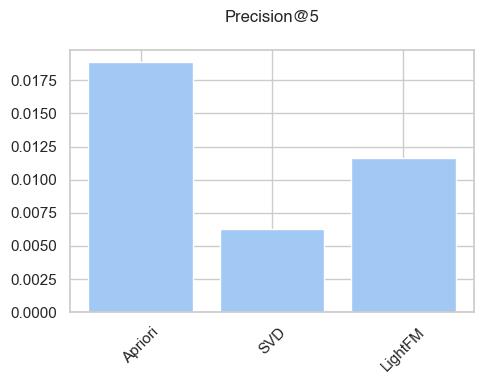

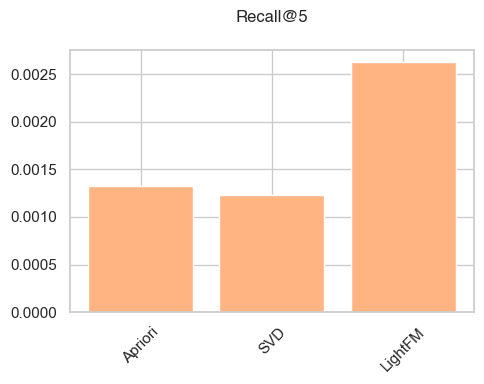

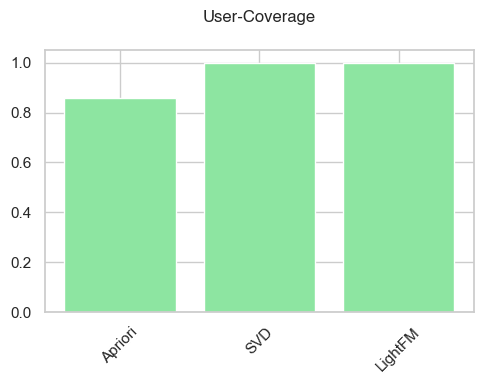

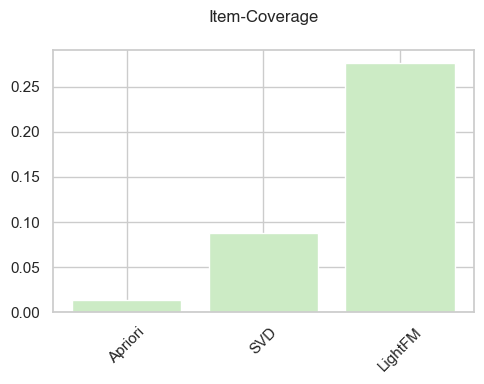

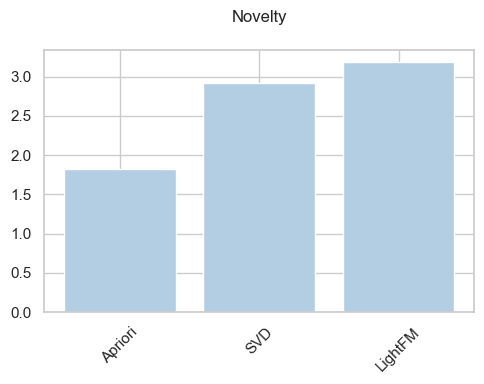

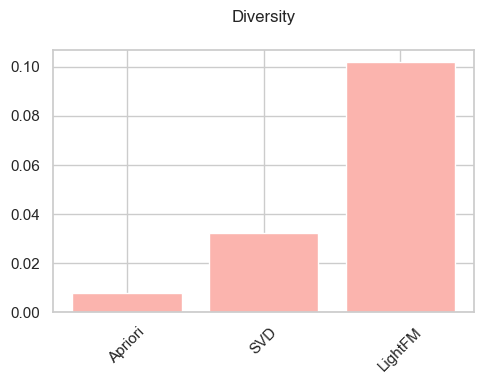

In [90]:
import seaborn as sns
metrics = ['Precision@5','Recall@5','User-Coverage','Item-Coverage','Novelty','Diversity']
for met in metrics:
    plt.figure(figsize=(5,4))
    color = '#ccebc5' if met == 'Item-Coverage' \
            else '#b3cde3' if met == 'Novelty' \
            else '#fbb4ae' if met == 'Diversity' \
            else sns.color_palette("pastel")[metrics.index(met) % 6]
    plt.bar(eval_df['Engine'], eval_df[met], color=color)
    plt.title(met, fontsize=12, family="Helvetica", pad=20)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [91]:
# Reshape from wide to long format
long_df = eval_df.melt(id_vars='Engine', var_name='Metric', value_name='Score')

# Create grouped bar chart
fig = go.Figure()

for metric in long_df['Metric'].unique():
    metric_df = long_df[long_df['Metric'] == metric]
    fig.add_trace(go.Bar(
        x=metric_df['Engine'],
        y=metric_df['Score'],
        name=metric
    ))

# Layout
fig.update_layout(
    font=dict(size=12, family="Helvetica"),
    title="Recommender Model Comparison – Evaluation Metrics",
    xaxis_title="Model",
    yaxis_title="Score",
    barmode='group',
    height=500,
    margin=dict(l=30, r=30, t=50, b=30),
    legend_title="Metric"
)

fig.show()